In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import scienceplots

import utils

In [2]:
plt.style.use(['science', 'grid'])
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times"],
    "font.size": 14})
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.4)

In [3]:
DATA_DIR = Path(f"../data/")
ICD_METHODS = [
    "icd-dispatch-only",
    "icd-postpone-only",
    "icd-hamming-distance",
    "icd-double-threshold",
]
COLORS = dict(zip(ICD_METHODS, ['#0C5DA5', '#FF2C00', '#FF9500', '#00B945']))
MARKERS = dict(zip(ICD_METHODS, ["d", "s", "x", "o"]))
NAMES = dict(zip(ICD_METHODS, ["DSHH", "ICD-postpone", "ICD-Hamming", "ICD-double"]))
LINESTYLES = dict(zip(ICD_METHODS, ["-", "-.", ":", "--"]))

In [4]:
FLEET = [
    "0.0", 
    "0.25", 
    "0.5", 
    "0.75", 
    "1.0", 
    "None"
]

In [5]:
df = pd.read_csv(DATA_DIR / "limited-fleet.csv")

best = df.groupby(["instance", "env_seed", "tw", "arrival"])["cost"].min().reset_index() # use infty as best
algs = df.groupby(["instance", "fleet", "env_seed", "tw", "arrival", "method"])["cost"].min().unstack().reset_index()

# Use hindsight infty as best.
best = best.sort_values(["instance", "env_seed", "tw", "arrival"])
algs = algs.sort_values(["fleet", "instance", "env_seed", "tw", "arrival"])
algs["best"] = best["cost"].tolist() * 6

In [6]:
df = algs

# Compute gap for each method.
methods = [
    "icd-dispatch-only",
    "icd-double-threshold",
    "icd-hamming-distance",
    "icd-postpone-only",
]
for method in methods:
    df[f"{method}_gap"] = (df[method] - df["best"]) / df["best"] * 100

df["category"] = df["instance"].apply(utils.get_category)

In [7]:
df = df[df["fleet"].isin(FLEET)]

In [8]:
means = df.groupby("fleet")[[method + "_gap" for method in methods]].mean()
means = means[-2:]

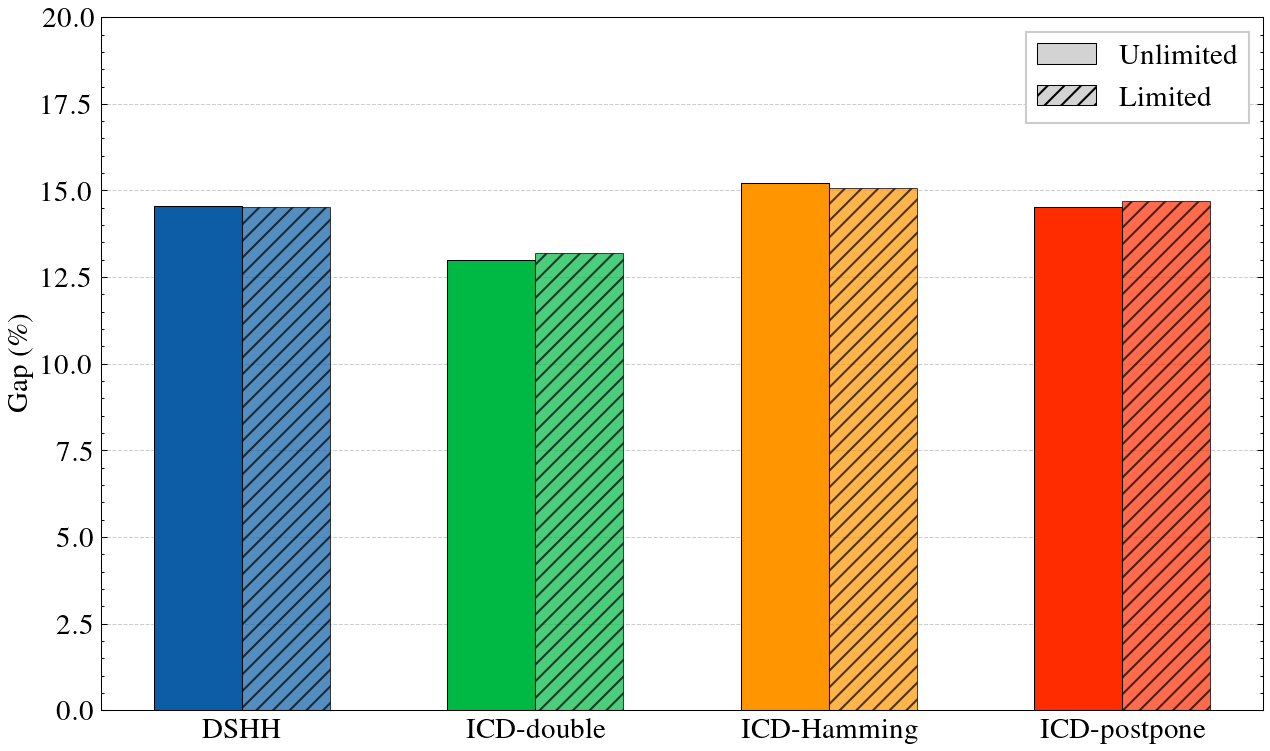

In [9]:
import matplotlib.patches as mpatches


fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=150)
bar_width = 0.3

for idx, (method_name_gap, gaps) in enumerate(means.items()):
    method = method_name_gap.removesuffix("_gap")
    plt.bar(
        idx - bar_width/2, 
        gaps[0], 
        bar_width, 
        edgecolor='black',
        linewidth=0.5,
        color=COLORS[method], 
        label=NAMES[method]
    )
    plt.bar(
        idx + bar_width/2, 
        gaps[1], 
        bar_width, 
        alpha=0.7,
        color=COLORS[method], 
        hatch="///", 
        edgecolor='black', 
        linewidth=0.5, 
    )

ax.set_ylim(0, 20)
ax.set_ylabel("Gap (\%)")

ax.grid(False, axis='x') # Show horizontal grid lines only
ax.set_xticks([0, 1, 2, 3], ["DSHH", "ICD-double", "ICD-Hamming", "ICD-postpone"])
plt.tick_params(axis='x', which='both', length=0) # no x-ticks

default_patch = mpatches.Patch(facecolor='lightgray', edgecolor='black', linewidth=0.5, label='Unlimited', zorder=3)
greedy_patch = mpatches.Patch(facecolor='lightgray', alpha=1, hatch='///', edgecolor='black', linewidth=0.5, label='Limited', zorder=3)
plt.legend(handles=[default_patch, greedy_patch], fontsize=14, fancybox=False, frameon=True)

plt.savefig("../figures/limited-fleet.pdf")